# Performance profiles

This notebook shows how to use the `corsort` package to determine the performance profiles of several sorting algorithms.

Here the following sorts will be compared:

- Top-down merge
- Binary insertion
- Binary insertion $\rho$
- Ford-Johnson $\rho$
- Quicksort
- ASort $\rho$
- Bottom-up merge $\rho$
- Multizip $\rho$
- Corsort $\rho$

First we load some packages.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from multiprocess.pool import Pool

from corsort import *

We populate the list of sorts we want to study. As we consider profiles, the scorer used matters (here $\rho$ is the main external scorer).

In [2]:
sort_list = [
    SortMergeTopDown(compute_history=True),
    SortBinaryInsertion(compute_history=True),
    WrapSortScorer(sort=SortBinaryInsertion(), scorer=jit_scorer_rho, compute_history=True),
    WrapSortScorer(sort=SortFordJohnson(), scorer=jit_scorer_rho, compute_history=True),
    SortQuick(compute_history=True),
    WrapSortScorer(sort=SortAsortQuickselect(), scorer=jit_scorer_rho, compute_history=True),
    WrapSortScorer(sort=SortMergeBottomUp(), scorer=jit_scorer_rho, compute_history=True),
    WrapSortScorer(sort=SortMultizip(), scorer=jit_scorer_rho, compute_history=True),
    JitCorsortDeltaMaxRho(compute_history=True)
]
legends = {'mergesort_top_down': 'Top-down merge',
 'binary_insertion_sort': 'Binary insertion',
 'binary_insertion_sort_rho': r'Binary insertion $\rho$',
 'ford_johnson_rho': r'Ford-Johnson $\rho$',
 'quicksort': 'Quicksort',
 'asort_quickselect_rho': r'Asort $\rho$',
 'mergesort_bottom_up_rho': r'Bottom-up merge $\rho$',
 'multizip_sort_rho': r'Multizip $\rho$',
 'corsort_delta_max_rho': r"Corsort-$\Delta$ $\rho$"}

We decide the value of $n$ to study and the number of trials.

In [3]:
n = 1000
nt = 10000

We now run the experiments, with some multi-processing to speed-up things.

In [4]:
with Pool() as p:
    convergence = evaluate_convergence(sort_list=sort_list, n=n, nt=nt, pool=p)

Evaluate convergence of mergesort_top_down for n = 1000


100%|██████████| 10000/10000 [28:20<00:00,  5.88it/s]


Evaluate convergence of binary_insertion_sort for n = 1000


100%|██████████| 10000/10000 [29:23<00:00,  5.67it/s] 


Evaluate convergence of binary_insertion_sort_rho for n = 1000


100%|██████████| 10000/10000 [58:20<00:00,  2.86it/s] 


Evaluate convergence of ford_johnson_rho for n = 1000


100%|██████████| 10000/10000 [1:08:32<00:00,  2.43it/s]


Evaluate convergence of quicksort for n = 1000


100%|██████████| 10000/10000 [40:55<00:00,  4.07it/s] 


Evaluate convergence of asort_quickselect_rho for n = 1000


100%|██████████| 10000/10000 [1:35:46<00:00,  1.74it/s] 


Evaluate convergence of mergesort_bottom_up_rho for n = 1000


100%|██████████| 10000/10000 [49:53<00:00,  3.34it/s] 


Evaluate convergence of multizip_sort_rho for n = 1000


100%|██████████| 10000/10000 [52:46<00:00,  3.16it/s] 


Evaluate convergence of corsort_delta_max_rho for n = 1000


100%|██████████| 10000/10000 [2:42:29<00:00,  1.03it/s]  


We save the raw results.

In [5]:
import dill as pickle
from pathlib import Path

fn = Path(f"profiles_n_{n}_nt_{nt}.pkl")
if fn.exists():
    with open(fn, 'rb') as f:
        convergence = pickle.load(f)
else:
    with open(fn, 'wb') as f:
        pickle.dump(convergence, f)

Then we display the results.

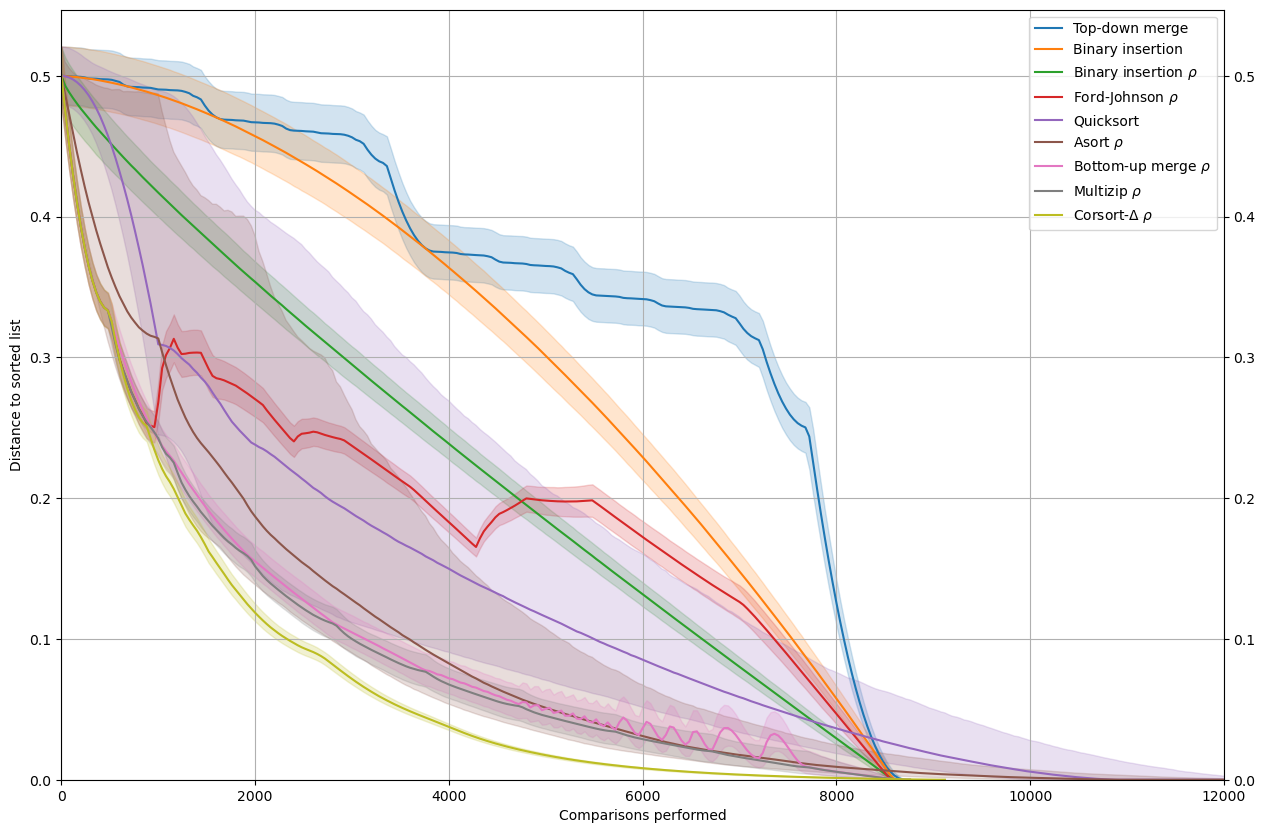

In [6]:
m = n*(n-1)/2
fig = plt.figure(figsize=(15, 10))
ax = plt.axes()
decim=40
color_dict = auto_colors(sort_list)
for name in legends:
    ref = convergence[name]
    color = color_dict[name]
    p_m = ref.shape[1]
    x = np.arange(p_m)[::decim]
    ref = ref[:, ::decim]
    q = np.zeros((5, ref.shape[1]))
    for i, per in enumerate([2.5, 50, 97.5]):
        q[i, :] = np.percentile(ref, per, axis=0)
    q = q/m
    ax.plot(x, q[1, :], label=legends[name], color=color)
    ax.fill_between(x, q[0, :], q[2, :], alpha=.2, color=color)
plt.legend()
plt.grid()
ax.tick_params(labelright=True, right=True)
plt.ylabel('Distance to sorted list')
plt.xlabel('Comparisons performed')
plt.ylim([0, None])
plt.xlim([0, 12000])
plt.show()